# **Market Basket Analysis - Parte 1**

---

<a href="https://midoritoyota.netlify.app/" target="_blank"><img align="left" src="portfolio.png" title="See my portfolio!"/></a><img align="left" src="espaco.png"/>

<a href="mailto:midori.toyota@gmail.com" target="_blank"><img align="left" src="gmail.png" title="Contact me!"/></a><img align="left" src="espaco.png"/>

<a href="https://www.linkedin.com/in/midoritoyota/" target="_blank"> <img align="left" src="linkedin.png" title="Add me on linkedin!" /></a><img align="left" src="espaco.png"/>

<a href="https://github.com/MidoriToyota" target="_blank"> <img align="left" src="github.png" title="Follow me on github!"/></a>

<br/><br/>



## **Definição do problema**

Nesse projeto, utilizarei os dados anônimos fornecidos pelo instacart para prever quais produtos adquiridos anteriormente estarão no próximo pedido de um usuário. O instacart é um aplicativo de compras online, onde os compradores selecionam os produtos no app e a entrega é feita na loja mais próxima à você.

Esta é a parte 1 (análise exploratória) de um dos projetos de conclusão do módulo Business Analytics da Formação Cientista de Dados da Data Science Academy (DSA)

Nessa primeira fase farei a análise exploratória dos dados para entender o conteúdo dos datasets e o perfil de compra dos usuários.

“The Instacart Online Grocery Shopping Dataset 2017”, Accessed from: 

https://www.instacart.com/datasets/grocery-shopping-2017 on 25/05/2020.

Post do VP da Instacart definindo o problema em detalhes:

https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2?gi=41f7b19cd164

## **Datasets**

Para carregar os datasets no google colab em R utilizei a solução descrita no link abaixo:

https://stackoverflow.com/questions/59746036/how-to-read-data-from-google-drive-using-r-in-colab/59781766#59781766


In [0]:
# Carregando arquivos csv que estão no google drive - caso use google colab
system("gdown --id 1_81hIRMXbE5IHIoJfEmL0NH9Yg0SkiaW") # orders.csv
system("gdown --id 1lCg5HbXqiHXyHWeXgzqbQn59ogCLJ3N3") # products.csv
system("gdown --id 1KlUykoQr9lnCgC--nOkNjQmmn0tAbSOH") # aisles.csv
system("gdown --id 1UmvR8ZnR1lXPstXsKhBSJJE_vsTr8B20") # departments.csv
system("gdown --id 1aOGKfIt-IGMRDsp4KFlJDeuoYgyy4aXU") # order_products__train.csv

In [1]:
# Carregado datasets
orders = read.csv("data/orders.csv", sep = ",")
products = read.csv("data/products.csv", sep = ",")
aisles = read.csv("data/aisles.csv", sep = ",")
departments = read.csv("data/departments.csv", sep = ",")
data_train = read.csv("data/order_products__train.csv", sep = ",")

## **Pacotes**

In [ ]:
# Carregar pacotes
library(ggplot2)
library(sqldf)
library(treemap)
library(dplyr)

## **Análise exploratória**

### **Volume de compras por dia da semana e por hora do dia**

Para analisar os dados do dataset orders quero primeiro entender como é a demanda dos produtos no decorrer do dia e no decorrer da semana.

O segundo passo é entender o perfil dos clientes. Estamos tendo uma boa taxa de retenção? Qual é o período de tempo médio entre compras de um usuário? 

**Estrutura dos dados (orders.csv)**

In [3]:
# Tamanho do dataset
dim(orders)

[1] 3421083       7

In [4]:
# Preview do dataframe
head(orders)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
,<int>,<int>,<fct>,<int>,<int>,<int>,<dbl>
1,2539329,1,prior,1,2,8,NA
2,2398795,1,prior,2,3,7,15
3,473747,1,prior,3,3,12,21
4,2254736,1,prior,4,4,7,29
5,431534,1,prior,5,4,15,28
6,3367565,1,prior,6,2,7,19


- `order_id`: order identifier
- `user_id`: customer identifier
- `eval_set`: which evaluation set this order belongs in - (see SET described below)
- `order_number`: the order sequence number for this user (1 = first, n = nth)
- `order_dow`: the day of the week the order was placed on
- `order_hour_of_day`: the hour of the day the order was placed on
- `days_since_prior`: days since the last order, capped at 30 (with NAs for order_number = 1)

**Quantidade de valores missing**

In [5]:
# Função - Proporção dos valores missing
propmiss = function(dataframe) {
  m = sapply(dataframe, function(x) {
    data.frame(
      nmiss = sum(is.na(x)),  
      n=length(x),
      propmiss = sum(is.na(x))/length(x) 
    )
  })
  d = data.frame(t(m))
  d = sapply(d, unlist)
  d = as.data.frame(d)
  d$variable = row.names(d)
  row.names(d) = NULL
  d = cbind(d[ncol(d)],d[-ncol(d)])
  return(d[order(d$propmiss), ])
}

# Proporção dos valores missing
propmiss(orders)

,variable,nmiss,n,propmiss
,<chr>,<dbl>,<dbl>,<dbl>
1,order_id,0,3421083,0.00000000
2,user_id,0,3421083,0.00000000
3,eval_set,0,3421083,0.00000000
4,order_number,0,3421083,0.00000000
5,order_dow,0,3421083,0.00000000
6,order_hour_of_day,0,3421083,0.00000000
7,days_since_prior_order,206209,3421083,0.06027594


6% dos pedidos contém valores NA para days_since_prior_order, ou seja, 6% dos pedidos desse dataset são referentes ao primeiro pedido feito pelo usuário. 

**Fluxo de compras na semana**

A contagem dos dias da semana começam no sábado, sendo sábado = 0, domingo = 1, segunda = 2, etc. Pelo gráfico abaixo, percebe-se que as pessoas fazem mais compras aos sábados e aos domingos, sendo quarta o dia de menor fluxo.

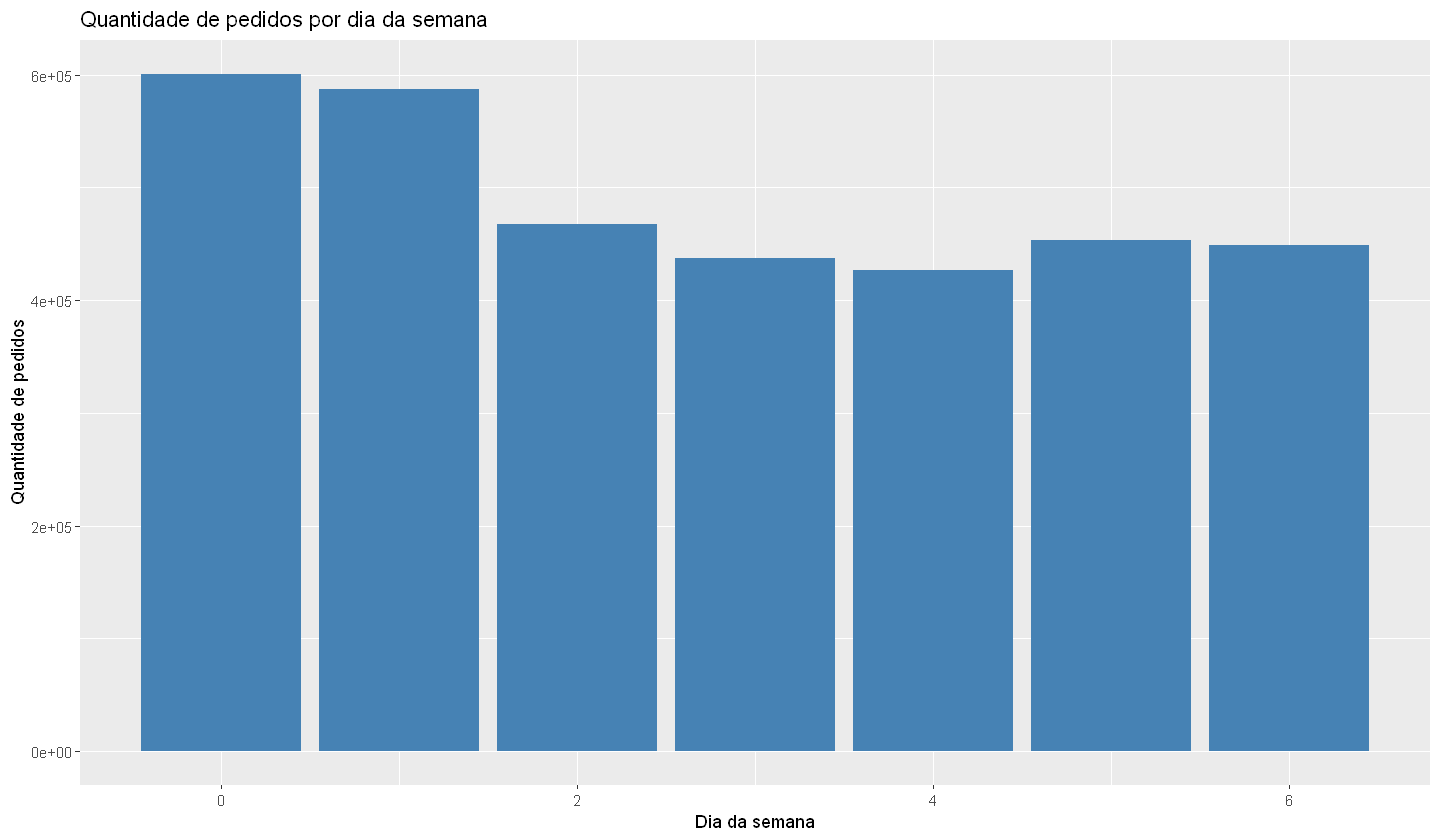

In [6]:
# Fluxo de compras na semana
options(repr.plot.width=12, repr.plot.height=7)
ggplot(orders) + 
  geom_bar(aes(x=order_dow), fill="steelblue") + ggtitle("Quantidade de pedidos por dia da semana")+
  xlab("Dia da semana") + ylab("Quantidade de pedidos")

**Fluxo de compras durante o dia**

Os gráficos indicam um maior fluxo de compras entre as 10 e as 16 horas. Depois desse horário há uma diminuição gradual do fluxo.

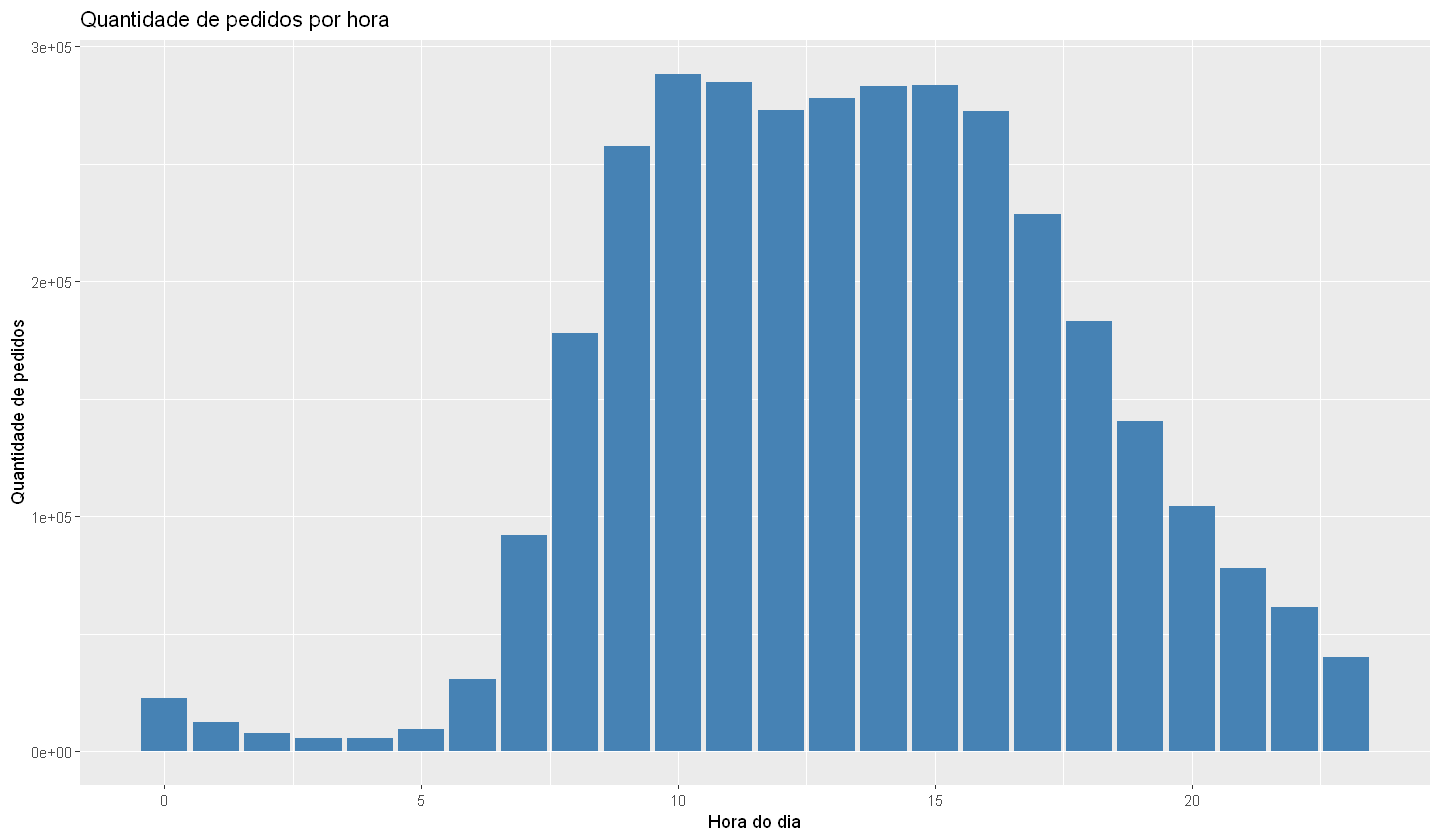

In [7]:
# Fluxo de compras em um dia
ggplot(orders) + 
  geom_bar(aes(x=order_hour_of_day), fill="steelblue") + ggtitle("Quantidade de pedidos por hora") +
  xlab("Hora do dia") + ylab("Quantidade de pedidos")

### **Products, Aisles e Departments**

É importante entender a relação entre essas tabelas e o que elas sozinhas significam. O que o instacart entende como categoria (aisle)? e departamento? Quais as categorias e departamentos com uma maior variedade de produtos?

**Estrutura dos dados (products.csv)**

In [8]:
# Tamanho do dataset de produtos
dim(products)

[1] 49688     4

In [9]:
# Estrutura do dataframe
head(products)

,product_id,product_name,aisle_id,department_id
,<int>,<fct>,<int>,<int>
1,1,Chocolate Sandwich Cookies,61,19
2,2,All-Seasons Salt,104,13
3,3,Robust Golden Unsweetened Oolong Tea,94,7
4,4,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,38,1
5,5,Green Chile Anytime Sauce,5,13
6,6,Dry Nose Oil,11,11


- `product_id`: product identifier
- `product_name`: name of the product
- `aisle_id`: foreign key
- `department_id`: foreign key

**Quantidade de Produtos por Categoria (Aisles)**

In [10]:
# Nº de produtos por aisles
products_by_aisles = sqldf( "SELECT ais.aisle_id, ais.aisle, pro.product_id 
                             FROM products AS pro
                             LEFT JOIN aisles AS ais
                             ON ais.aisle_id = pro.aisle_id" )

# 10 aisles com maior variedade de produtos
sqldf( "SELECT aisle, COUNT(product_id) AS n_products
        FROM products_by_aisles 
        GROUP BY aisle
        ORDER BY n_products DESC
        LIMIT 10")

aisle,n_products
<fct>,<int>
missing,1258
candy chocolate,1246
ice cream ice,1091
vitamins supplements,1038
yogurt,1026
chips pretzels,989
tea,894
packaged cheese,891
frozen meals,880


Me parece que existe uma variedade enorme de alimentos não saudáveis. 1246 tipos diferentes de chocolate? Interessante!

**Produtos por Departamento**



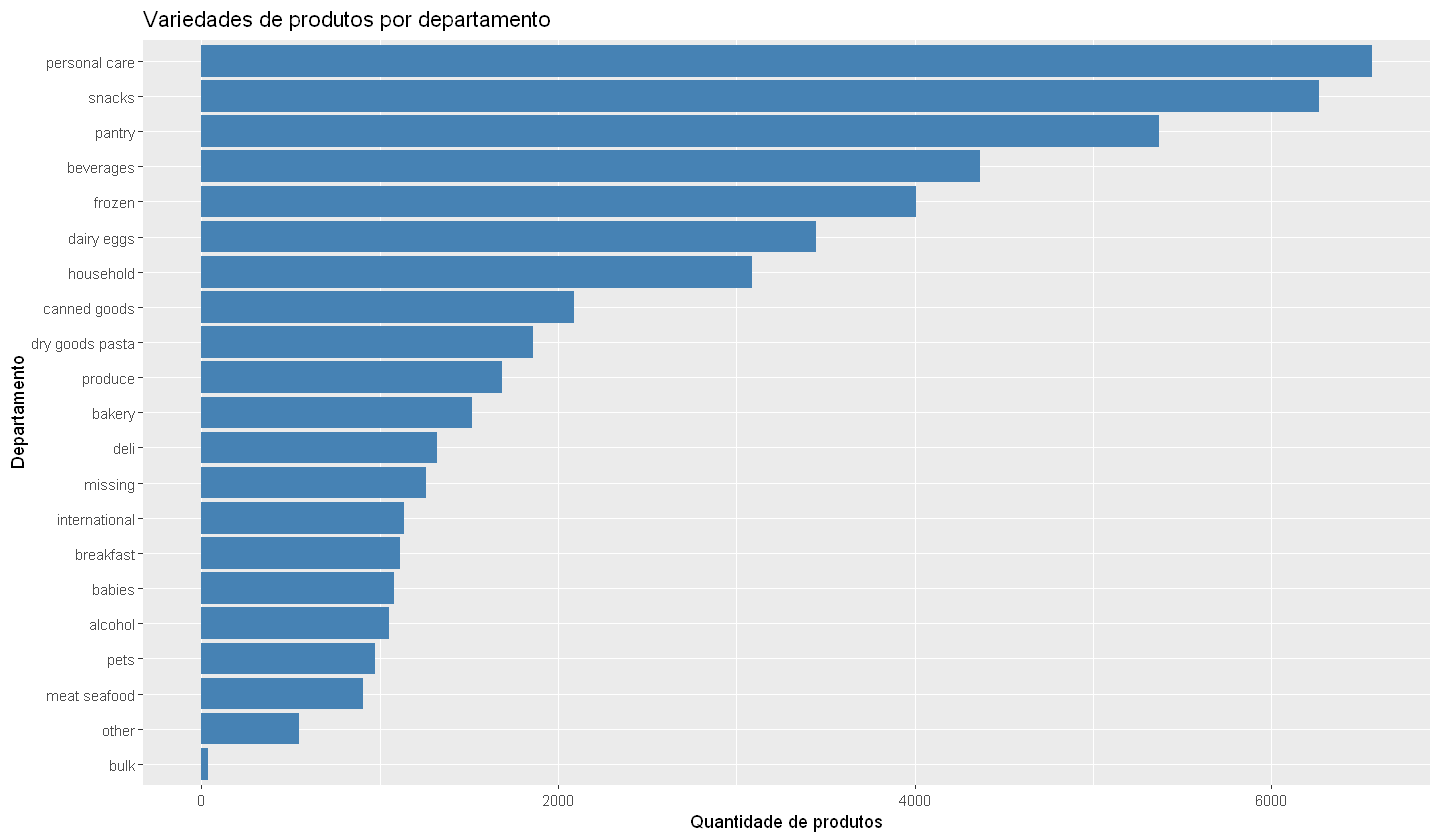

In [11]:
# Nº de produtos por departamento
products_by_depto = sqldf( "SELECT dep.department_id, dep.department, pro.product_id 
                            FROM products AS pro
                            LEFT JOIN departments AS dep
                            ON pro.department_id = dep.department_id" ) 

# Departamentos com maior variedade de produtos
n_products_by_depto = sqldf( "SELECT department, COUNT(product_id) AS n_products
                              FROM products_by_depto
                              GROUP BY department
                              ORDER BY n_products DESC")

# Ordenar em ordem decrescente (preparação para o plot)
n_products_by_depto$department = factor(n_products_by_depto$department, levels = n_products_by_depto$department[order(n_products_by_depto$n_products)])

# Departamentos com maior variedade de produtos
ggplot(n_products_by_depto) + 
  geom_col(aes(x=department, y=n_products), fill="steelblue") + ggtitle("Variedades de produtos por departamento")+
  xlab("Departamento") + ylab("Quantidade de produtos")+ coord_flip()

**Relação entre produtos, departamentos e categorias (aisles)**

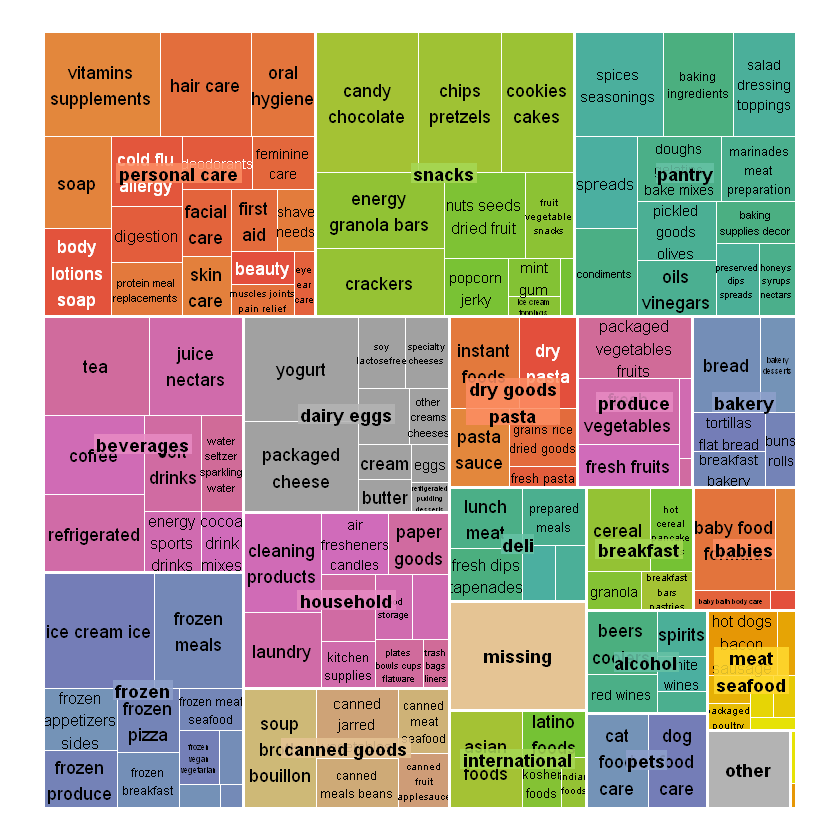

In [12]:
# Preparo dos dados para visualização do treemap
options(repr.plot.width=7, repr.plot.height=7)
tmp = sqldf( " SELECT *
               FROM products AS pro
               LEFT JOIN aisles AS ais
               ON pro.aisle_id = ais.aisle_id " )

tmp = tmp[,c(-2,-3,-5)] # Remover variáveis product_name, aisle_id(1), aisle_id(2)

tmp = sqldf( " SELECT *
               FROM tmp 
               LEFT JOIN departments AS dep
               ON tmp.department_id = dep.department_id " )

tmp = tmp[,c(-2,-4)] # Remover variáveis department_id

tmp = sqldf( " SELECT department, aisle, COUNT(product_id) AS n_products
               FROM tmp 
               GROUP BY department, aisle " )

# Plot treemap
treemap(tmp,index=c("department","aisle"),vSize="n_products",title="",palette="Set2",border.col="#FFFFFF")

### **Análise do perfil do cliente**

As próximas variáveis (`order_number` e `days_since_prior_order`) são variáveis que definem o perfil do usuário e portanto vou calculá-las de modo agregado.

**Perfil do cliente baseado no nº de Dias desde a última compra**

O `days_since_prior_order` revela se um cliente tem o costume de fazer compras semanais, quizenais etc. Para entender melhor, vou pegar o exemplo do cliente nº 100 (aleatório).

Analizando abaixo, o cliente nº 100 já está em sua 6ª compra  e compra de 30 em 30 dias mais ou menos. Para definir esse número para cada usuário, usarei a média dos `days_since_prior_order`.


In [28]:
# Exemplo dos dados do cliente nº 100
sqldf("SELECT * FROM orders WHERE user_id = 100")

order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
<int>,<int>,<fct>,<int>,<int>,<int>,<dbl>
680467,100,prior,1,3,18,NA
3159209,100,prior,2,0,15,18
2443738,100,prior,3,5,17,30
2337051,100,prior,4,3,20,30
2875733,100,prior,5,1,18,26
3302990,100,test,6,5,19,30


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



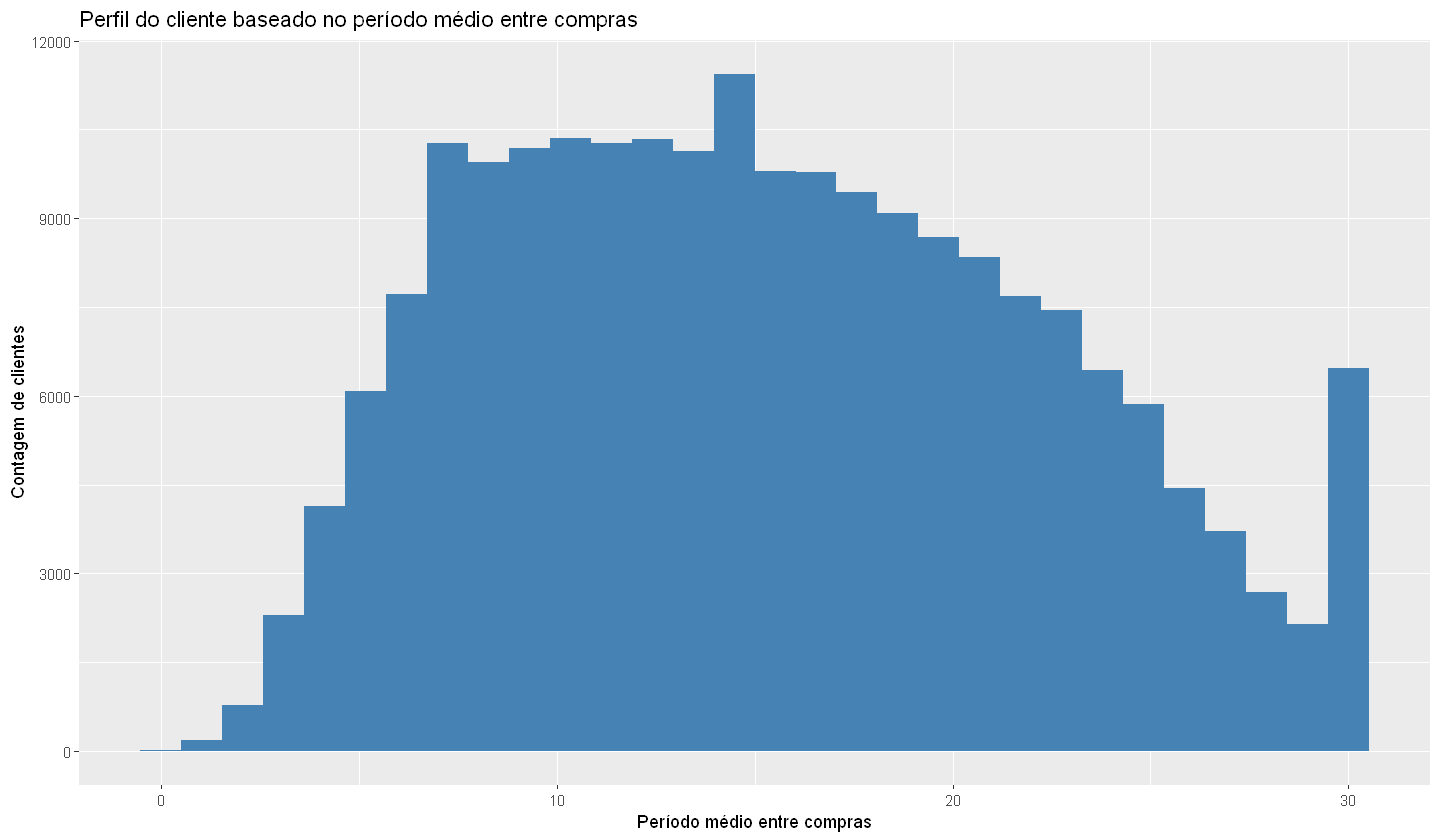

In [19]:
# Período médio entre compras (truncado em 30 dias)
options(repr.plot.width=12, repr.plot.height=7)
user_days_since_order = sqldf( "SELECT user_id, AVG(days_since_prior_order) AS avg_days
                                FROM orders 
                                WHERE days_since_prior_order IS NOT NULL
                                GROUP BY user_id")

# Histograma
ggplot(user_days_since_order) + 
  geom_histogram(aes(x=avg_days), fill="steelblue") + ggtitle("Perfil do cliente baseado no período médio entre compras") +
  xlab("Período médio entre compras") + ylab("Contagem de clientes")

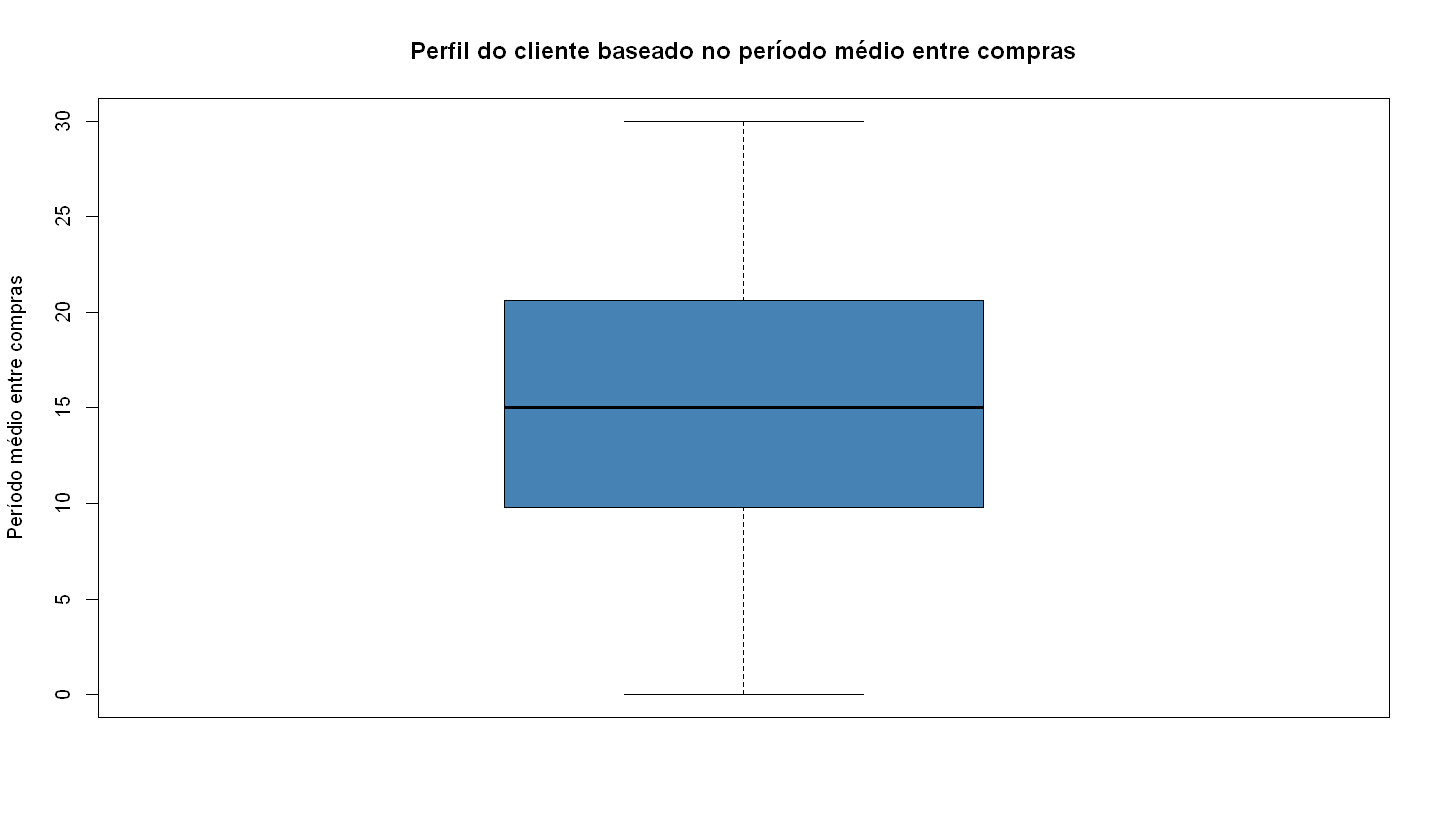

In [20]:
# Box plot - uma outra forma de visualizar
options(repr.plot.width=12, repr.plot.height=7)
boxplot(user_days_since_order$avg_days, ylab = "Período médio entre compras" , col = "steelblue", main = "Perfil do cliente baseado no período médio entre compras")

Analizando os gráficos acima, a maioria dos clientes faz compras em média quinzenalemente, a maioria entre 10 à 20 dias. Poucas pessoas fazem compras semanais.


**Perfil do cliente baseado no nº de pedidos já feitos**

O order_number revela qual é o grau de maturidade do cliente, se ele é um cliente antigo ou novo. Para isso, devo considerar apenas o maior `order_number` de cada usuário.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



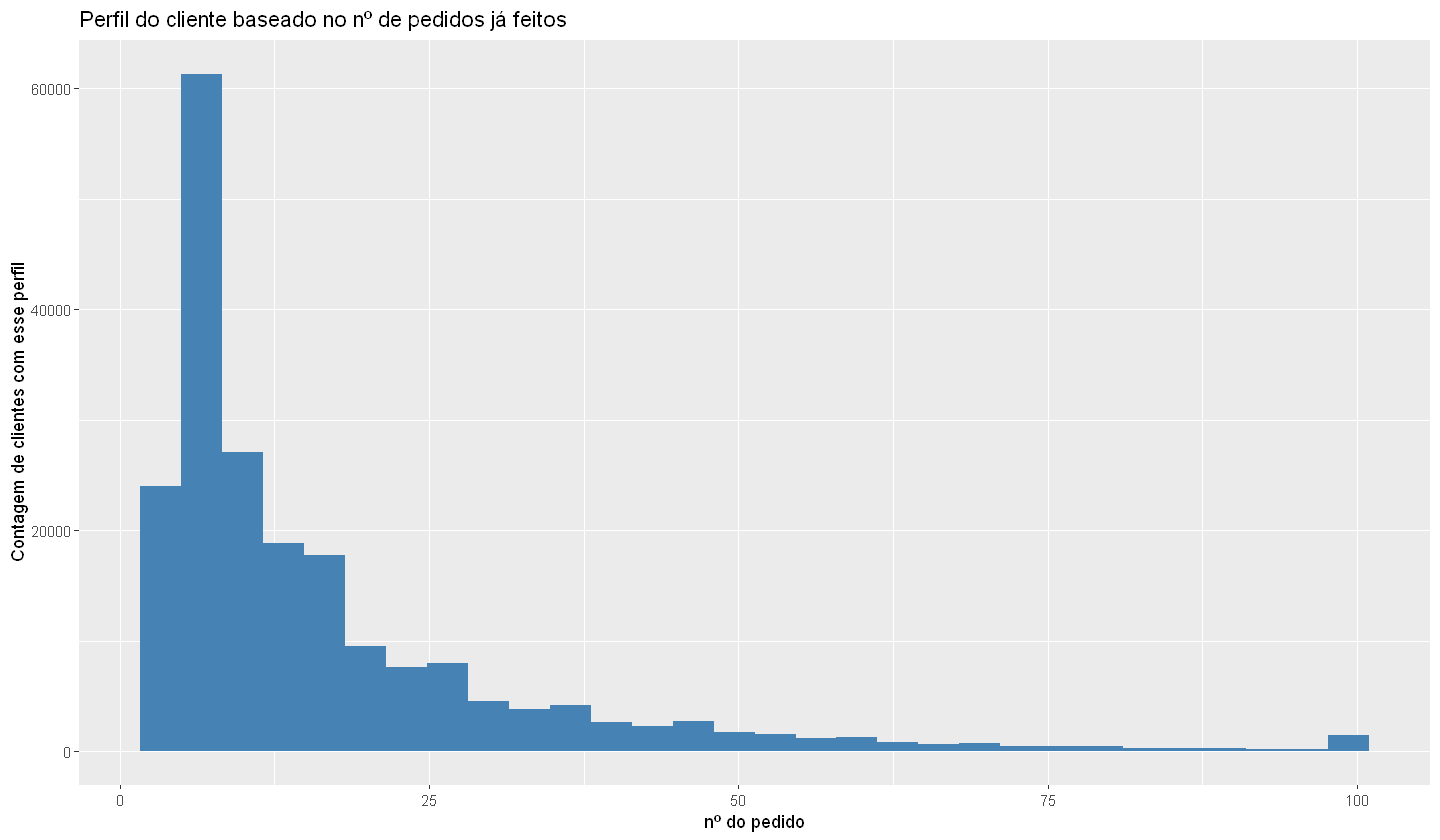

In [21]:
# Pedido mais recente feito pelo usuário 
options(repr.plot.width=12, repr.plot.height=7)
user_order_number = sqldf( " SELECT user_id, MAX(order_number) as max_order_number
                             FROM orders
                             GROUP BY user_id " )

# Histograma
ggplot(user_order_number) + 
  geom_histogram(aes(x=max_order_number), fill="steelblue") + ggtitle("Perfil do cliente baseado no nº de pedidos já feitos")+
  xlab("nº do pedido") + ylab("Contagem de clientes com esse perfil")

Pelo gráfico acima vemos que os clientes são muito eufóricos no início. Há muitos clientes que estão fazendo sua 10ª compra pelo site, porém, há uma queda brusca na retenção de usuários após o 15º pedido e esse número continua caindo gradativamente.

### **Análise dos pedidos**

Abaixo temos o dataset  `data_train` para a criação do modelo. Esse dataset contém quais produtos foram comprados em cada ordem de compra. Através dele, conseguiremos montar um modelo que mostra que tipos de produtos devem ser recomendados para que os clientes comprem novamente. Vou analisar brevemente esse dataset, mas uma explorção mais profunda será feita com o pacote APRIORI em uma segunda etapa.

In [5]:
# Número total de produtos
dim(data_train)

[1] 1384617       4

In [6]:
# Número total de pedidos
length(unique(data_train$order_id))

[1] 131209

In [36]:
# Estrutura dos datasets (os dois tem a mesma estrutura)
head(data_train)

,order_id,product_id,add_to_cart_order,reordered
,<int>,<int>,<int>,<int>
1,1,49302,1,1
2,1,11109,2,1
3,1,10246,3,0
4,1,49683,4,0
5,1,43633,5,1
6,1,13176,6,0


- `order_id`: foreign key
- `product_id`: foreign key
- `add_to_cart_order`: order in which each product was added to cart
- `reordered`: 1 if this product has been ordered by this user in the past, 0 otherwise

---

<a href="https://midoritoyota.netlify.app/" target="_blank"><img align="left" src="portfolio.png" title="See my portfolio!"/></a><img align="left" src="espaco.png"/>

<a href="mailto:midori.toyota@gmail.com" target="_blank"><img align="left" src="gmail.png" title="Contact me!"/></a><img align="left" src="espaco.png"/>

<a href="https://www.linkedin.com/in/midoritoyota/" target="_blank"> <img align="left" src="linkedin.png" title="Add me on linkedin!" /></a><img align="left" src="espaco.png"/>

<a href="https://github.com/MidoriToyota" target="_blank"> <img align="left" src="github.png" title="Follow me on github!"/></a>

<br/><br/>
